# 01: Data Analysis, Molecule Processing and First Simple Models
## Aqueous Solubility Prediction from Molecular Structure
### Ian Sharff

This notebook closely follows the work of Delaney _et. al_ in determining a rudimentary method for estimating the aqueous solubility of organic compounds based entirely on properties calculated from two-dimensional molecular structure and connectivity.$^{[1]}$ This notebook also takes inspiration from an <a href="https://towardsdatascience.com/how-to-use-machine-learning-for-drug-discovery-1ccb5fdf81ad">article</a> by Nantasenamat [2] that explores the same 1,144 molecules used in this study and provided a helpful introduction to the `rdkit` library and its Python API for representing molecules and performing computations.$^{[2]}$

The objective of Delaney's work was to leverage the fact that a compound's aqueous solubility shows strong correlation with it's octanol-water partition coefficient, $\log P_{octanol}$, which is generally a good indicator of hydrophilicity. In addition to $\log P$, three other features were used to construct a multiple linear regression to predict solubility as $\log S$. Here, the same four features are used to replicate this.

- Octanol-water partition coefficient: ___cLogP___
- Number of rotatable bonds: ___RB___
- Aromatic proportion: ___AP___
- Molecular weight: ___MW___

This notebook contains code for extracting molecular representations and properties using the RDKit library to parse SMILES strings and perform computations of the above features. Then, simple linear regressions are performed for regressor, followed by a multiple linear regression with all four. Further exploration with other modelling techniques will be outlined in subsequent notebooks.

In [1]:
# Array and DataFrame construction/manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Molecular representation and feature extraction
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw

# Linear regression models
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Custom helper functions (see tools/helpers.py)
from tools import helpers as h

## Data Processing and Feature Extraction

The data was obtained from Chanin Nantasenamat's page on GitHub (https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv) which contain's Delaney's predicted values, known experimental values for LogS, and SMILES strings to be parsed with `rdkit`. The dataset is included in this repository at `./data/raw_data/delaney.csv` for convenience.

In [2]:
filepath = 'data/raw_data/delaney.csv'
column_names = ['name', 'logS_expt', 'logS_pred', 'SMILES']

# Read in file using custom headers
delaney = pd.read_csv(filepath, names=column_names, header=0)

display(delaney.head())
print()
display(delaney.info())

,name,logS_expt,logS_pred,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1144 non-null   object 
 1   logS_expt  1144 non-null   float64
 2   logS_pred  1144 non-null   float64
 3   SMILES     1144 non-null   object 
dtypes: float64(2), object(2)
memory usage: 35.9+ KB


None

### Creating Molecule Objects

The `rdkit.Chem` module handles the parsing of SMILES strings and the calculation of each of the features. This is demonstrated with a sample molecule, 1,2,3,5-Tetrachlorobenzene, and the helper function `get_feature_array` in `tools/helpers.py` contains the code for taking a sequence of molecule objects to produce a corresponding array of features.

    Compound Name: 1,2,3,5-Tetrachlorobenzene     
          SMILES: Clc1cc(Cl)c(Cl)c(Cl)c1          
--------------------------------------------------


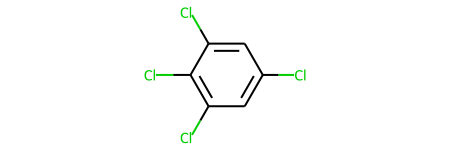

cLogP:	4.3002
MW:	215.8940
NB:	0
AP:	0.6


In [3]:
# Create an array of molecule objects from SMILES strings in the DataFrame
molecules = delaney.SMILES.map(Chem.MolFromSmiles).to_numpy()

# Take a sample molecule to demonstrate preprocessing
sample_molecule = molecules[10]

# Get predictors cLogP, RB, and for a sample molecule
sample_name = delaney.name[10]
sample_smiles = delaney.SMILES[10]
sample_cLogP = Descriptors.MolLogP(sample_molecule)
sample_MW = Descriptors.MolWt(sample_molecule)
sample_RB = Descriptors.NumRotatableBonds(sample_molecule)

# Calculate the Aromatic Proportion (#aromatic atoms / #heavy atoms)
n_atoms = sample_molecule.GetNumAtoms()
n_aromatics = sum([sample_molecule.GetAtomWithIdx(i).GetIsAromatic() for i in range(n_atoms)])
n_heavy = Descriptors.HeavyAtomCount(sample_molecule)

sample_AP = n_aromatics / n_heavy
print('='*50)
print(f"Compound Name: {sample_name}".center(50))
print(f"SMILES: {sample_smiles}".center(50))
print('-'*50)

display(sample_molecule)
print(f"cLogP:\t{sample_cLogP:.4f}")
print(f"MW:\t{sample_MW:.4f}")
print(f"NB:\t{sample_RB}")
print(f"AP:\t{sample_AP}")
print('='*50)

In [4]:
# Create target, features, and data DataFrames for visualizations
target = delaney['logS_expt']
features = h.get_feature_array(molecules)
data = pd.concat([features, target], axis=1)

data.head()

,MW,cLogP,RB,AP,logS_expt
0,167.850,2.5954,0.0,0.0,-2.18
1,133.405,2.3765,0.0,0.0,-2.00
2,167.850,2.5938,1.0,0.0,-1.74
3,133.405,2.0289,1.0,0.0,-1.48
4,187.375,2.9189,1.0,0.0,-3.04


## Data Understanding

Here, histograms are created for each of the features to understand their distributions, and on first glance it appears that the most normally distributed regressor is cLogP. The AP and RB features each contain many zeros understandably, and the molecular weight feature appears right-skewed.

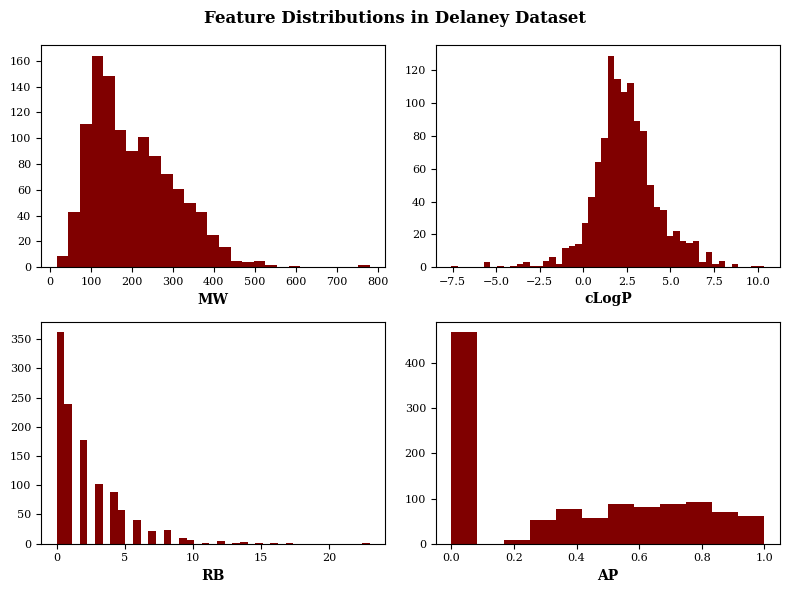

In [5]:
with mpl.style.context('images/notebook.mplstyle'):
    fig, axes = plt.subplots(2, 2)
    fig.suptitle('Feature Distributions in Delaney Dataset')
    for ax, col in zip(axes.flatten(), features.columns): 
        ax.hist(x=features[col], bins='auto')
        ax.set_xlabel(col)

    fig.tight_layout()
    plt.savefig('images/plots/feature_distributions.png')
    plt.show();

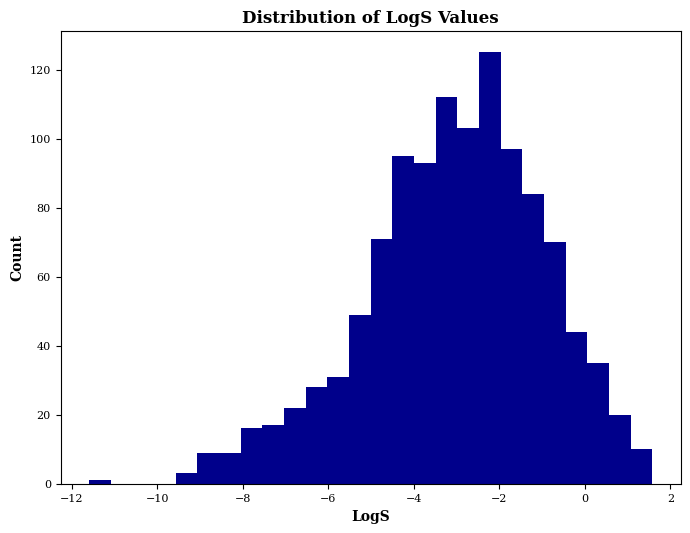

In [6]:
with mpl.style.context('images/notebook.mplstyle'):
    fig, ax = plt.subplots()
    ax.hist(x=target, bins='auto', color='darkblue')
    ax.set(title='Distribution of LogS Values', xlabel='LogS', ylabel='Count')
    
    plt.savefig('images/plots/LogS_distribution.png')
    plt.show()

From the following heatmap, it is clear that cLogP has the largest magnitude of correlation with the target (-0.83) which is aligned with the results of the study.

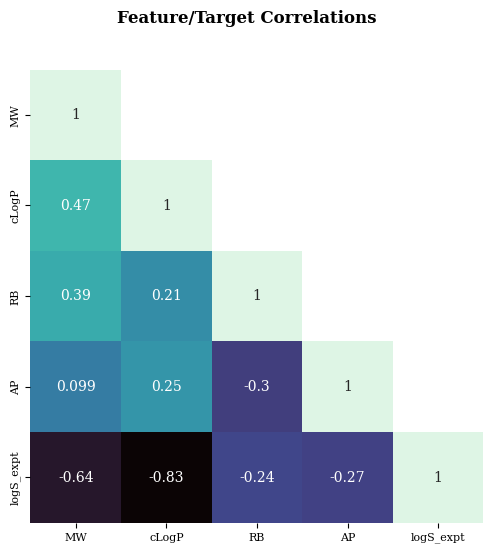

In [7]:
with mpl.style.context('images/notebook.mplstyle'):
    correlations = data.corr()
    plt.figure()
    plt.suptitle('Feature/Target Correlations')
    sns.heatmap(
        correlations,
        annot=True,
        cmap='mako',
        cbar=False,
        square=True,
        mask=np.triu(np.ones_like(correlations), 1)
    )
    plt.savefig('images/plots/corr_heatmap.png')
    plt.show()

## Linear Regressions

Before using all features, simple linear regressions are performed for each of the features using `sklearn.linear_model.LinearRegression`. $R^2$ scores are calculated and formulas are generated and appear as annotations on the figures. Again, it seems that the highest-performing predictor will be cLogP, followed by molecular weight. 

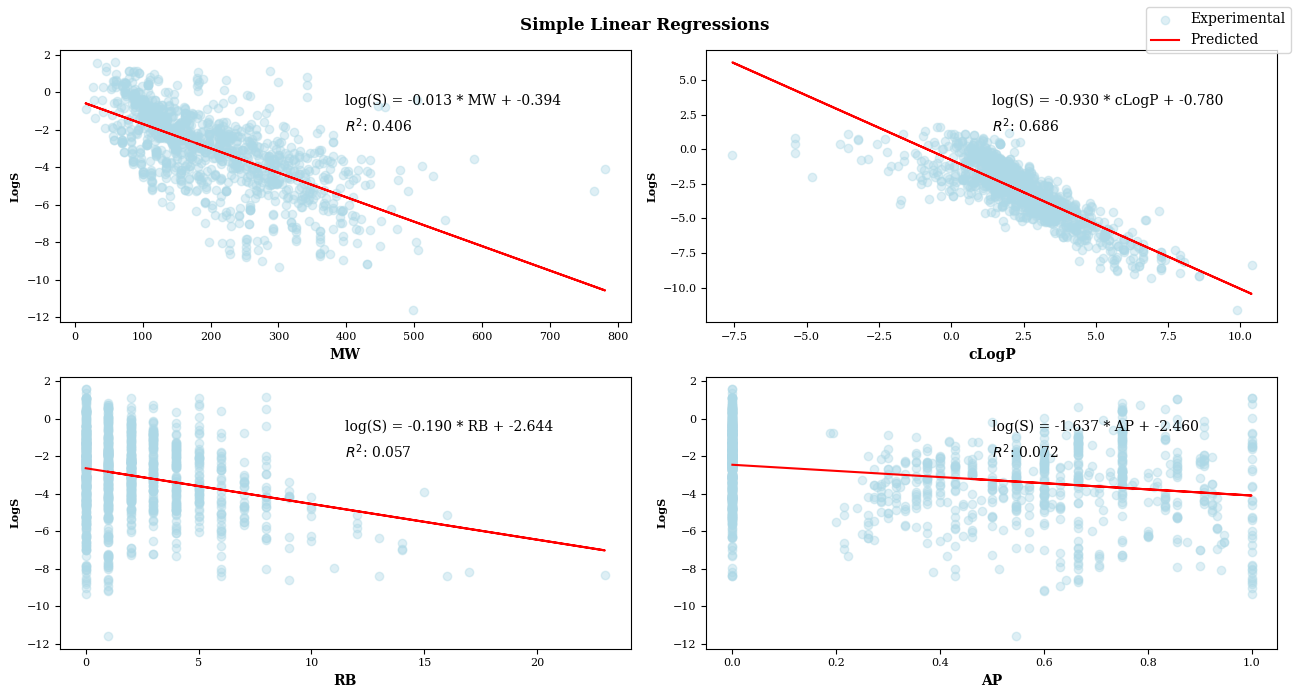

In [8]:
X = features.to_numpy()
y_true = target.to_numpy()

with mpl.style.context('images/notebook.mplstyle'):
    fig, axes = plt.subplots(2, 2, figsize=(13, 7))
    fig.suptitle('Simple Linear Regressions')
    for ax, col in zip(axes.flatten(), features.columns):
        x = features[col].to_numpy().reshape(-1, 1)

        model = LinearRegression()
        model.fit(x, y_true)

        y_pred = model.predict(x)
        score = model.score(x, y_true)

        coefficient = model.coef_[0]
        intercept = model.intercept_
        formula = f"log(S) = {coefficient:.3f} * {col} + {intercept:.3f}"

        ax.set_xlabel(col)
        ax.set_ylabel('LogS', size=8)

        true = ax.scatter(x, y_true, color='lightblue', marker='o', alpha=0.4, label='Experimental')
        pred, = ax.plot(x, y_pred, 'r', label='Predicted')

        ax.annotate(formula, (.5, .8), xycoords='axes fraction', size=10)
        ax.annotate(f"$R^2$: {score:.3f}", (.5, .7), xycoords='axes fraction', size=10)

    fig.legend(handles=[true, pred], loc='upper right')
    fig.tight_layout()
    plt.savefig('images/plots/simple_lrs.png')
    plt.show();

### Multiple Linear Regression with All Features

0.770099670806285


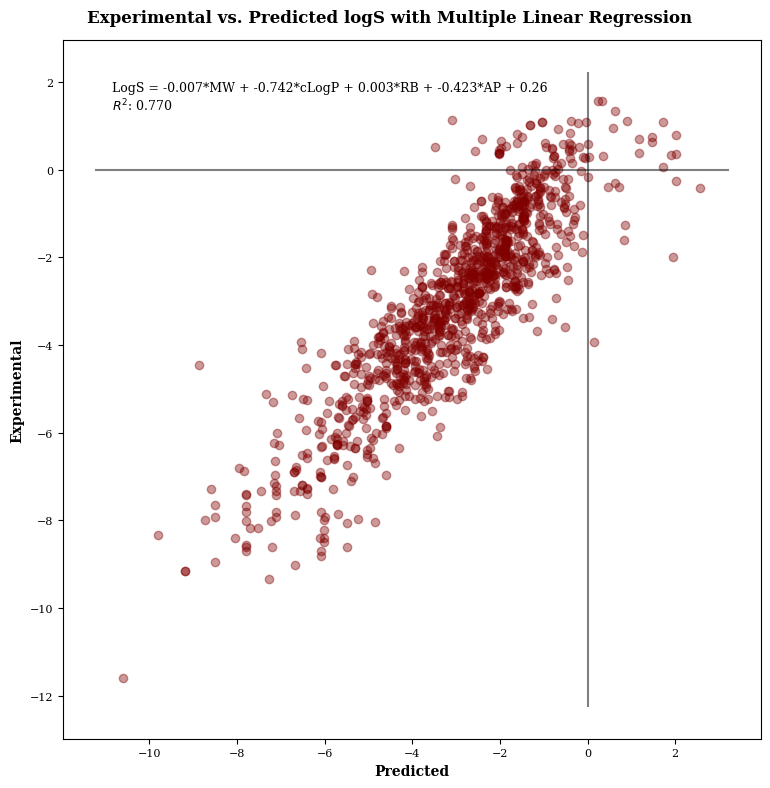

In [9]:
lrs = LinearRegression()
lrs.fit(X, y_true)

r2_score = lrs.score(X, y_true)
print(r2_score)
y_pred = lrs.predict(X)

feature_names = features.columns
coefficients = lrs.coef_
intercept = lrs.intercept_

terms = [f"{coef:.3f}*{name}" for coef, name in zip(coefficients, feature_names)] + [f"{intercept:.2f}"]
formula = 'LogS = '+ ' + '.join(terms)
annotation = formula + '\n' + f"$R^2$: {r2_score:.3f}"

with mpl.style.context('images/notebook.mplstyle'):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    
    fig.suptitle('Experimental vs. Predicted logS with Multiple Linear Regression')
    
    ax.set_ylabel('Experimental')
    ax.set_xlabel('Predicted')
    
    ax.scatter(y_pred, y_true, marker='o', alpha=0.4)
    ax.set_aspect('equal')
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.hlines(0, xmin, xmax, color='black', alpha=0.5)
    ax.vlines(0, ymin, ymax, color='black', alpha=0.5)

    ax.annotate(annotation, (.07, .9), xycoords='axes fraction', size=9)
    
    fig.tight_layout()
    plt.savefig('images/plots/multiple_lr.png')
    plt.show();

## References

- [1] Delaney, John S. _J. Chem. Inf. Comput. Sci._ __2004__. 
- [2] Nantasenamat, C. (2020, June 7). How to Use Machine Learning for Drug Discovery [web log]. Retrieved November 27, 2021, from https://towardsdatascience.com/how-to-use-machine-learning-for-drug-discovery-1ccb5fdf81ad. 